# Face Detection with UniFace

This notebook demonstrates how to use the UniFace library for face detection. We'll cover:

1. Basic face detection with different detectors
2. Understanding detection outputs (bounding boxes, confidence, landmarks)
3. Visualizing results
4. Comparing different detection methods

## Prerequisites

Make sure you have UniFace installed:
```bash
pip install -e ".[dev]"
```

In [6]:
# Set backend to ONNX (MLX weights not yet available on GitHub)
import os
os.environ['UNIFACE_BACKEND'] = 'onnx'

# Import required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time

# UniFace imports
from uniface.detection import RetinaFace, SCRFD, YOLOv5Face
from uniface.visualization import draw_detections

# For displaying images in notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

print(f"Backend: {os.environ.get('UNIFACE_BACKEND', 'default')}")

Backend: onnx


## 1. Load an Image

First, let's load an image to test face detection. You can replace the path with your own image.

In [7]:
# Helper function to display images (converts BGR to RGB for matplotlib)
def show_image(image, title="Image", figsize=(10, 8)):
    """Display an image using matplotlib."""
    plt.figure(figsize=figsize)
    # OpenCV uses BGR, matplotlib uses RGB
    if len(image.shape) == 3:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        image_rgb = image
    plt.imshow(image_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

Image loaded successfully!
Image size: 1470x980 (width x height)


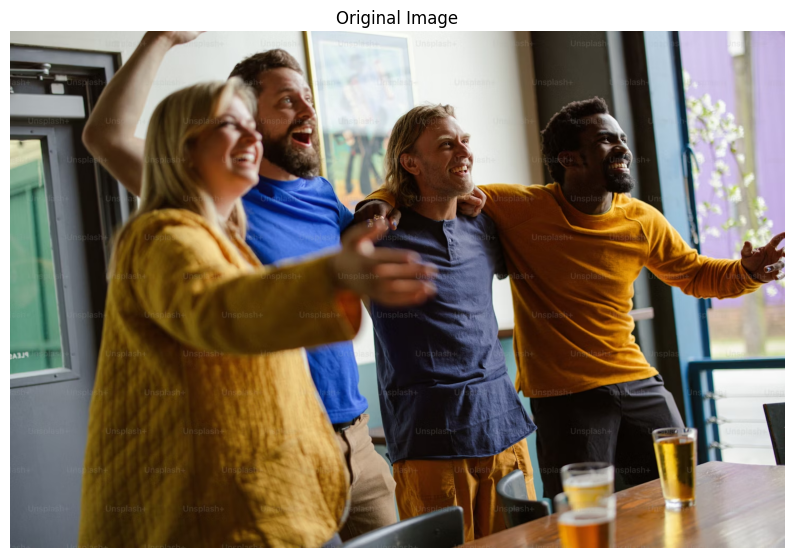

In [8]:
# Load your image - replace with your own image path
# Available images: image1.png, image2.png, image3.png, image4.png

image_path = "../images/image1.png"  # Update this path

# Load the image
image = cv2.imread(image_path)

if image is None:
    print(f"Could not load image from '{image_path}'")
    print("Please update the image_path variable with a valid image path.")
else:
    h, w = image.shape[:2]
    print(f"Image loaded successfully!")
    print(f"Image size: {w}x{h} (width x height)")
    show_image(image, "Original Image")

## 2. Basic Face Detection with RetinaFace

RetinaFace is one of the most accurate face detectors available. It provides:
- Bounding box coordinates
- Detection confidence score
- 5-point facial landmarks (eyes, nose, mouth corners)

In [9]:
# Initialize the RetinaFace detector
# conf_thresh: minimum confidence to consider a detection valid (0.0 to 1.0)
# nms_thresh: non-maximum suppression threshold (removes overlapping boxes)

detector = RetinaFace(
    conf_thresh=0.5,  # Only keep detections with >50% confidence
    nms_thresh=0.4    # Remove overlapping boxes with >40% IoU
)

print("RetinaFace detector initialized!")

ConnectionError: Download failed for 'RetinaFaceWeights.MNET_V2' (MLX)

In [ ]:
# Run face detection
start_time = time.time()
faces = detector.detect(image)
detection_time = time.time() - start_time

print(f"Detection completed in {detection_time*1000:.1f}ms")
print(f"Found {len(faces)} face(s)")

## 3. Understanding Detection Output

Each detection is a dictionary containing:
- `bbox`: Bounding box as `[x1, y1, x2, y2]` (top-left and bottom-right corners)
- `confidence`: Detection confidence score (0.0 to 1.0)
- `landmarks`: 5 facial landmarks as array of shape `(5, 2)`
  - Index 0: Left eye
  - Index 1: Right eye
  - Index 2: Nose tip
  - Index 3: Left mouth corner
  - Index 4: Right mouth corner

In [ ]:
# Examine detection results
for i, face in enumerate(faces):
    print(f"\n--- Face {i + 1} ---")
    
    # Bounding box
    bbox = face['bbox']
    print(f"Bounding Box: [x1={bbox[0]:.1f}, y1={bbox[1]:.1f}, x2={bbox[2]:.1f}, y2={bbox[3]:.1f}]")
    print(f"Face Size: {bbox[2] - bbox[0]:.1f}w x {bbox[3] - bbox[1]:.1f}h pixels")
    
    # Confidence
    print(f"Confidence: {face['confidence']:.3f} ({face['confidence']*100:.1f}%)")
    
    # Landmarks
    landmarks = face['landmarks']
    landmark_names = ['Left Eye', 'Right Eye', 'Nose', 'Left Mouth', 'Right Mouth']
    print("Landmarks:")
    for name, (x, y) in zip(landmark_names, landmarks):
        print(f"  {name}: ({x:.1f}, {y:.1f})")

## 4. Visualize Detections

UniFace provides a `draw_detections` function for visualization, or you can draw manually.

In [ ]:
# Method 1: Using UniFace's draw_detections function
output_image = image.copy()

if faces:
    bboxes = [face['bbox'] for face in faces]
    scores = [face['confidence'] for face in faces]
    landmarks = [face['landmarks'] for face in faces]
    
    draw_detections(
        output_image,
        bboxes,
        scores,
        landmarks,
        vis_threshold=0.5,
        draw_score=True,
        fancy_bbox=True
    )

show_image(output_image, f"Face Detection Results ({len(faces)} faces)")

In [ ]:
# Method 2: Custom visualization with more control
def draw_faces_custom(image, faces, color=(0, 255, 0), thickness=2):
    """Draw face detections with custom styling."""
    output = image.copy()
    
    # Colors for landmarks
    landmark_colors = [
        (255, 0, 0),    # Left eye - Blue
        (0, 0, 255),    # Right eye - Red
        (0, 255, 0),    # Nose - Green
        (255, 255, 0),  # Left mouth - Cyan
        (255, 0, 255),  # Right mouth - Magenta
    ]
    
    for i, face in enumerate(faces):
        bbox = face['bbox'].astype(int)
        conf = face['confidence']
        landmarks = face['landmarks']
        
        # Draw bounding box
        cv2.rectangle(output, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, thickness)
        
        # Draw confidence label with background
        label = f"Face {i+1}: {conf:.2f}"
        label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
        cv2.rectangle(output, 
                      (bbox[0], bbox[1] - label_size[1] - 10),
                      (bbox[0] + label_size[0], bbox[1]),
                      color, -1)
        cv2.putText(output, label, (bbox[0], bbox[1] - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
        
        # Draw landmarks with different colors
        for j, (x, y) in enumerate(landmarks):
            cv2.circle(output, (int(x), int(y)), 4, landmark_colors[j], -1)
            cv2.circle(output, (int(x), int(y)), 5, (255, 255, 255), 1)
    
    return output

# Apply custom visualization
custom_output = draw_faces_custom(image, faces)
show_image(custom_output, "Custom Visualization with Colored Landmarks")

## 5. Compare Different Detectors

UniFace supports three face detection methods:
- **RetinaFace**: High accuracy, good for general use
- **SCRFD**: Efficient and accurate, good balance
- **YOLOv5Face**: Fast, based on YOLO architecture

In [ ]:
# Initialize all detectors
detectors = {
    'RetinaFace': RetinaFace(conf_thresh=0.5),
    'SCRFD': SCRFD(conf_thresh=0.5),
    'YOLOv5Face': YOLOv5Face(conf_thresh=0.5),
}

print("All detectors initialized!")

In [ ]:
# Compare detection results and timing
results = {}

for name, det in detectors.items():
    # Warm-up run
    _ = det.detect(image)
    
    # Timed run (average of 5)
    times = []
    for _ in range(5):
        start = time.time()
        faces = det.detect(image)
        times.append(time.time() - start)
    
    avg_time = np.mean(times) * 1000  # Convert to ms
    results[name] = {
        'faces': faces,
        'num_faces': len(faces),
        'avg_time_ms': avg_time,
        'fps': 1000 / avg_time
    }
    
    print(f"{name:15} | Faces: {len(faces):2} | Time: {avg_time:6.1f}ms | FPS: {1000/avg_time:5.1f}")

In [ ]:
# Visualize comparison side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (name, result) in zip(axes, results.items()):
    output = image.copy()
    faces = result['faces']
    
    if faces:
        bboxes = [f['bbox'] for f in faces]
        scores = [f['confidence'] for f in faces]
        landmarks = [f['landmarks'] for f in faces]
        draw_detections(output, bboxes, scores, landmarks, vis_threshold=0.5)
    
    # Convert BGR to RGB for matplotlib
    output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    ax.imshow(output_rgb)
    ax.set_title(f"{name}\n{result['num_faces']} faces | {result['avg_time_ms']:.1f}ms")
    ax.axis('off')

plt.tight_layout()
plt.show()

## 6. Working with Different Input Sources

You can also detect faces from:
- Webcam frames
- Video files
- URLs (by downloading first)

In [ ]:
# Example: Process a batch of images from a directory
def process_image_directory(directory_path, detector, max_images=5):
    """Process all images in a directory."""
    directory = Path(directory_path)
    
    if not directory.exists():
        print(f"Directory not found: {directory}")
        return []
    
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.webp'}
    image_files = [f for f in directory.iterdir() 
                   if f.suffix.lower() in image_extensions][:max_images]
    
    results = []
    for img_path in image_files:
        img = cv2.imread(str(img_path))
        if img is not None:
            faces = detector.detect(img)
            results.append({
                'path': img_path,
                'faces': faces,
                'num_faces': len(faces)
            })
            print(f"{img_path.name}: {len(faces)} face(s)")
    
    return results

# Uncomment to process a directory:
# batch_results = process_image_directory('../images', detector)

## 7. Save Results

Save the annotated image and detection data.

In [ ]:
# Save annotated image
output_path = "../outputs/detected_faces.jpg"
Path("../outputs").mkdir(exist_ok=True)

cv2.imwrite(output_path, output_image)
print(f"Saved annotated image to: {output_path}")

In [ ]:
# Save detection data as JSON
import json

def serialize_faces(faces):
    """Convert face detections to JSON-serializable format."""
    serialized = []
    for face in faces:
        serialized.append({
            'bbox': face['bbox'].tolist(),
            'confidence': float(face['confidence']),
            'landmarks': face['landmarks'].tolist()
        })
    return serialized

# Save to JSON
detection_data = {
    'image_path': image_path,
    'detector': 'RetinaFace',
    'num_faces': len(faces),
    'faces': serialize_faces(faces)
}

json_path = "../outputs/detections.json"
with open(json_path, 'w') as f:
    json.dump(detection_data, f, indent=2)

print(f"Saved detection data to: {json_path}")
print("\nJSON contents:")
print(json.dumps(detection_data, indent=2))

## Summary

In this notebook, we learned how to:

1. **Load images** using OpenCV and display them with matplotlib
2. **Initialize detectors** (RetinaFace, SCRFD, YOLOv5Face) with custom thresholds
3. **Run face detection** and understand the output format
4. **Visualize results** using built-in or custom drawing functions
5. **Compare detectors** to choose the best one for your use case
6. **Save results** as images and JSON data

### Next Steps

- Try the `FaceAnalyzer` for full pipeline (detection + recognition + age/gender)
- Explore face recognition with `ArcFace` for face matching
- Use `AgeGender` and `Emotion` for attribute prediction
- Check out `run_detection.py` for webcam support